**Rules for the code:**

- Include all the code you used for your report in this file. The code for any section in the report should go under the same section in this file.
- Any missing code will result in -20% from its corresponding section in the report.
- Any irrelevant code will result in -20% from its corresponding section in the report.
- Make sure that you run your code before rendering, so all the necessary visual/numeric outputs are visible.
- Any code that is not properly run or throws errors will be considered missing/irrelevant.

## 3) Data

## 5) Data Cleaning 

In [6]:
import matplotlib.pyplot as plt


In [7]:
import pandas as pd
crash = pd.read_csv('Traffic_Crashes_-_Crashes_20251109.csv')


/var/folders/_l/b38cj6s513957kzfnj_20g5m0000gn/T/ipykernel_59612/3943388798.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  crash = pd.read_csv('Traffic_Crashes_-_Crashes_20251109.csv')


### a) Cleaning - Question 1

#### Component 1 Cleaning

In [8]:
#Missing crash location data
print(crash[crash['LATITUDE'].isna() | crash['LONGITUDE'].isna()].shape)


(7569, 48)


In [9]:
#checking for data with valid location but invalid long or lat
lat_null = crash['LATITUDE'].isna()
long_null = crash['LONGITUDE'].isna()
location_not_null = crash['LOCATION'].notna()
missing_coords_with_location = (lat_null | long_null) & location_not_null
number_of_entries = crash[missing_coords_with_location].shape[0]
print(f"Number of entries with missing LAT/LONG but a valid LOCATION value: {number_of_entries}")

Number of entries with missing LAT/LONG but a valid LOCATION value: 0


In [11]:
columns_to_check = [
    'LATITUDE',
    'LONGITUDE'
]
crash_location_filtered = crash.dropna(subset=columns_to_check).copy()

In [12]:
#Longitude outliers on crash data
Q1 = crash_location_filtered['LONGITUDE'].quantile(0.25)
Q3 = crash_location_filtered['LONGITUDE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = crash_location_filtered[(crash_location_filtered['LONGITUDE'] < lower_bound) | (crash_location_filtered['LONGITUDE'] > upper_bound)]
outliers_iqr.shape


(2746, 48)

In [13]:
#Latitude outliers on crash data
Q1 = crash_location_filtered['LATITUDE'].quantile(0.25)
Q3 = crash_location_filtered['LATITUDE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = crash_location_filtered[(crash_location_filtered['LATITUDE'] < lower_bound) | (crash_location_filtered['LATITUDE'] > upper_bound)]
outliers_iqr.shape


(66, 48)

#### Component 2 Cleaning

In [134]:

#types of crash injuries
crash_location_filtered["MOST_SEVERE_INJURY"].unique()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


array(['NONINCAPACITATING INJURY', 'NO INDICATION OF INJURY',
       'REPORTED, NOT EVIDENT', 'INCAPACITATING INJURY', 'FATAL', nan],
      dtype=object)

In [135]:
#amount of missing injury data
injury_columns = [
    'INJURIES_FATAL',
    'INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING',
    'INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_NO_INDICATION',
    'INJURIES_UNKNOWN'
]
print(crash_location_filtered.shape)
crash_location_filtered[injury_columns].isna().any(axis=1).sum()


(993245, 48)


np.int64(2155)

In [136]:
#filter out missing injury data
crash_injury_filtered = crash_location_filtered.dropna(subset=injury_columns).copy()
crash_injury_filtered.shape

(991090, 48)

In [141]:
negative_value_check = {}
for column in injury_columns:
    has_negative = (crash_injury_filtered[column]<0).any()
    negative_value_check[column] = has_negative
check_results = pd.Series(negative_value_check)

print("Presence of negative values")
print(check_results)


Presence of negative values
INJURIES_FATAL                   False
INJURIES_INCAPACITATING          False
INJURIES_NON_INCAPACITATING      False
INJURIES_REPORTED_NOT_EVIDENT    False
INJURIES_NO_INDICATION           False
INJURIES_UNKNOWN                 False
dtype: bool


In [142]:
#create injury score crash data
crash_injury_filtered['INJURIES_SCORE'] = crash_injury_filtered['INJURIES_FATAL']*4 + crash_injury_filtered['INJURIES_INCAPACITATING']*3 + crash_injury_filtered['INJURIES_NON_INCAPACITATING']*2 + \
crash_injury_filtered['INJURIES_REPORTED_NOT_EVIDENT']*1 + crash_injury_filtered['INJURIES_UNKNOWN']*1 + crash_injury_filtered['INJURIES_NO_INDICATION']*0.5

In [143]:
#Injury outliers on crash data
Q1 = crash_injury_filtered['INJURIES_SCORE'].quantile(0.25)
Q3 = crash_injury_filtered['INJURIES_SCORE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = crash_injury_filtered[(crash_injury_filtered['INJURIES_SCORE'] < lower_bound) | (crash_injury_filtered['INJURIES_SCORE'] > upper_bound)]
outliers_iqr.shape


(133869, 49)

In [144]:
crash_injury_filtered['INJURIES_SCORE'].describe()

count    991090.000000
mean          1.349047
std           1.122410
min           0.000000
25%           1.000000
50%           1.000000
75%           1.500000
max          44.000000
Name: INJURIES_SCORE, dtype: float64

### b) Cleaning - Question 2

In [186]:
weather = pd.read_csv('KMDW.csv')
weather['DateTime_String'] = weather['Date'].astype(str) + ' ' + weather['Time'].astype(str)

weather['US_Time'] = pd.to_datetime(weather['DateTime_String'], format = '%Y-%m-%d %I:%M %p')

In [212]:
crash_injury_filtered['US_Time'] = pd.to_datetime(
    crash_injury_filtered['CRASH_DATE'], 
    format='%m/%d/%Y %I:%M:%S %p'
)

In [213]:
weather = weather.sort_values(by = 'US_Time', ascending = True)
crash_injury_filtered = crash_injury_filtered.sort_values(by = 'US_Time', ascending = True)


In [214]:
from datetime import timedelta
merged_crash = pd.merge_asof(
    crash_injury_filtered, 
    weather, 
    on='US_Time', 
    direction='nearest', 
    tolerance=timedelta(minutes=120)
)

In [215]:
merged_crash['DateTime_String'].isna().sum()
#DateTime_String is guaranteed to be in every entry of weather, so if a merged_crash row did not have this data, 
#there must have been no available weather report within 2 hours of it

np.int64(118251)

In [216]:
merged_crash.shape

(991090, 62)

In [217]:
merged_crash = merged_crash.dropna(subset=['DateTime_String'])


In [225]:
#missing data
print(merged_crash['Temperature_C'].isna().sum())
print(merged_crash['Humidity_%'].isna().sum())
print(merged_crash['Speed in km/h'].isna().sum())
print(merged_crash['Precipitation Rate in mm'].isna().sum())
print(merged_crash['POSTED_SPEED_LIMIT'].isna().sum())



0
0
0
0
0


In [226]:
#Outlier check
columns = ['Temperature_C', 'Humidity_%', 'Speed in km/h', 'Precipitation Rate in mm', "POSTED_SPEED_LIMIT"]
for i in columns:
    Q1 = merged_crash[i].quantile(0.25)
    Q3 = merged_crash[i].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_iqr = merged_crash[(merged_crash[i] < lower_bound) | (merged_crash[i] > upper_bound)]
    
    print(f"# of outliers using IQR method for {i}")
    print(len(outliers_iqr.index))
    print(outliers_iqr[i].describe())

    

# of outliers using IQR method for Temperature_C
269
count    269.000000
mean     -27.881524
std        1.223919
min      -29.440000
25%      -28.330000
50%      -28.330000
75%      -27.220000
max      -25.560000
Name: Temperature_C, dtype: float64
# of outliers using IQR method for Humidity_%
0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Humidity_%, dtype: float64
# of outliers using IQR method for Speed in km/h
7423
count    7423.000000
mean       43.953377
std         4.560694
min        40.230000
25%        40.230000
50%        41.830000
75%        46.660000
max        64.360000
Name: Speed in km/h, dtype: float64
# of outliers using IQR method for Precipitation Rate in mm
21687
count    21687.000000
mean         3.884547
std          3.397462
min          2.540000
25%          2.540000
50%          2.540000
75%          2.540000
max         40.640000
Name: Precipitation Rate in mm, dtype: float64
# of outliers using

### c) Cleaning - Question 3

In [399]:
crash_injury_filtered["CRASH_DATE"] = pd.to_datetime(crash_injury_filtered["CRASH_DATE"])


In [400]:
last_date = crash_injury_filtered["CRASH_DATE"].max()

last_month_start = last_date.replace(day=1)


crash_date_filtered = crash_injury_filtered[crash_injury_filtered["CRASH_DATE"] < last_month_start - timedelta(days=1)]
#no missing values

In [353]:
cutoff_date = pd.to_datetime('2015-10-01')

pre_2015_data = crash_date_filtered[crash_date_filtered['CRASH_DATE'] < cutoff_date]
post_2015_data = crash_date_filtered[crash_date_filtered['CRASH_DATE'] >= cutoff_date]

total_crashes = len(crash_date_filtered)
pre_2015_count = len(pre_2015_data) / total_crashes * 100
post_2015_count = len(post_2015_data) / total_crashes * 100
print(f"The % of crashes before October 2015 is {pre_2015_count}%, and the % after October 2015 is {post_2015_count}%")

The % of crashes before October 2015 is 0.2020161147556738%, and the % after October 2015 is 99.79798388524432%


In [354]:
cutoff_date = pd.to_datetime('2017-10-01')

pre_2017_data= crash_date_filtered[crash_date_filtered['CRASH_DATE'] < cutoff_date]
post_2017_data = crash_date_filtered[crash_date_filtered['CRASH_DATE'] >= cutoff_date]

total_crashes = len(crash_date_filtered)
pre_2017_count = len(pre_2017_data) / total_crashes * 100
post_2017_count = len(post_2017_data) / total_crashes * 100
print(f"The % of crashes before Oct 2015 is {pre_2017_count}%, and the % after Oct 2015 is {post_2017_count}%")

The % of crashes before Oct 2015 is 10.891571871506827%, and the % after Oct 2015 is 89.10842812849317%


In [355]:
#the rate at which crash reports rose per week
def calculate_average_weekly_rate(df, start_date_str, end_date_str, date_col='CRASH_DATE'):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)
    filtered_df = df[(df[date_col] >= start_date) & (df[date_col] < end_date)]
    monthly_reports = filtered_df.set_index(date_col).resample('M').size()
    monthly_increase = monthly_reports.diff()
    average_rate = monthly_increase.mean(skipna=True)
    
    return average_rate

start_date_x = '2015-10-01' 
end_date_y = '2017-10-01'  


avg_increase = calculate_average_weekly_rate(
    crash_date_filtered, 
    start_date_x, 
    end_date_y, 
    date_col='CRASH_DATE'
)


print(f"{avg_increase:.2f} reports per month (Average Increase) from 10/1/2015 to 10/1/2017")
    

269.61 reports per month (Average Increase) from 10/1/2015 to 10/1/2017


In [356]:
#the rate at which crash reports rose per week
def calculate_average_weekly_rate(df, start_date_str, end_date_str, date_col='CRASH_DATE'):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)
    filtered_df = df[(df[date_col] >= start_date) & (df[date_col] < end_date)]
    monthly_reports = filtered_df.set_index(date_col).resample('M').size()
    monthly_increase = monthly_reports.diff()
    average_rate = monthly_increase.mean(skipna=True)
    
    return average_rate

start_date_x = '2017-10-01' 
end_date_y = '2018-10-01'  


avg_increase = calculate_average_weekly_rate(
    crash_date_filtered, 
    start_date_x, 
    end_date_y, 
    date_col='CRASH_DATE'
)


print(f"{avg_increase:.2f} reports per month (Average Increase) after 2017 October")
    

-10.91 reports per month (Average Increase) after 2017 October


In [401]:
cutoff_date = pd.to_datetime('2017-10-01')

crash_date_filtered = crash_date_filtered[crash_date_filtered["CRASH_DATE"] >= cutoff_date]

print(crash_date_filtered['CRASH_DATE'].isna().sum())


0


## 6) Data Analysis

### a) Analysis 1

#### a) Analysis 1 Component 1

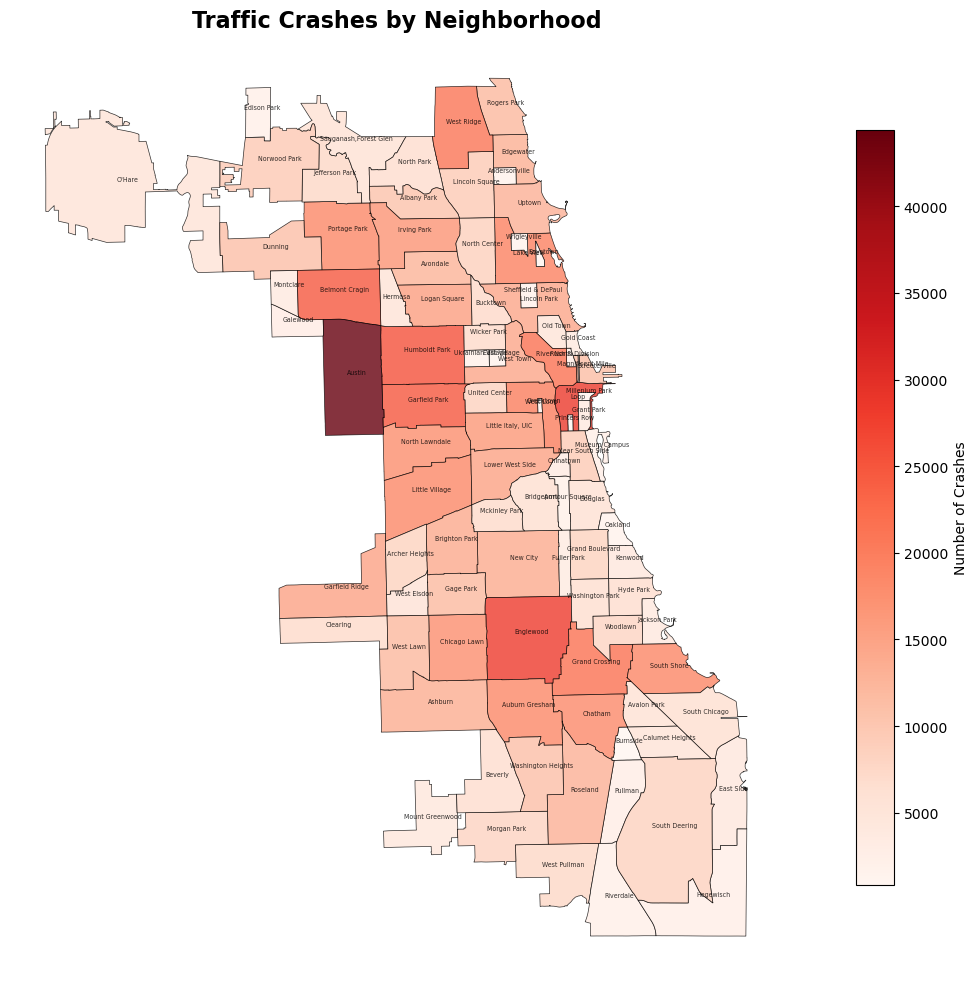

In [119]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt


neighborhoods = pd.read_csv("Neighborhoods_2012b_20251209.csv")
neighborhoods['geometry'] = neighborhoods['the_geom'].apply(wkt.loads)
gdf_neighborhoods = gpd.GeoDataFrame(neighborhoods, geometry='geometry', crs='EPSG:4326')

crash_gdf = gpd.GeoDataFrame(
    crash_location_filtered,
    geometry=gpd.points_from_xy(crash_location_filtered.LONGITUDE, crash_location_filtered.LATITUDE),
    crs="EPSG:4326"
)

neighborhoods_with_crashes = gpd.sjoin(
    gdf_neighborhoods, 
    crash_gdf, 
    how='left', 
    predicate='contains'
)

crash_counts = neighborhoods_with_crashes.groupby(neighborhoods_with_crashes.index).size()
gdf_neighborhoods['crash_count'] = crash_counts
gdf_neighborhoods['crash_count'] = gdf_neighborhoods['crash_count'].fillna(0)

name_column = 'PRI_NEIGH'

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf_neighborhoods.plot(
    column='crash_count',
    ax=ax,
    cmap='Reds',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8,
    legend=True,
    legend_kwds={
        'label': 'Number of Crashes',
        'orientation': 'vertical',
        'shrink': 0.8
    }
)

for idx, row in gdf_neighborhoods.iterrows():
    centroid = row.geometry.centroid
    
    if name_column in row:
        name = row[name_column]
    else:
        name = f"Neighborhood {idx}"
    
    ax.annotate(
        text=name,
        xy=(centroid.x, centroid.y),
        xytext=(3, 3),  
        textcoords="offset points",
        fontsize=3.0,
        alpha=0.8,
        ha='center'
    )

ax.set_title('Traffic Crashes by Neighborhood', fontsize=16, fontweight='bold')
ax.set_axis_off()  

plt.tight_layout()
plt.show()

In [125]:
gdf_neighborhoods.sort_values(by='crash_count', ascending = False).head(15)


,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,crash_count
94,MULTIPOLYGON (((-87.75619515209075 41.91546954...,Austin,AUSTIN,"170,037,750.826","55,473.345911","MULTIPOLYGON (((-87.7562 41.91547, -87.75588 4...",44420
26,MULTIPOLYGON (((-87.61397431379372 41.88840881...,Loop,LOOP,"31,485,185.0318","52,640.907563","MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ...",28511
19,MULTIPOLYGON (((-87.62854256542131 41.79413908...,Englewood,ENGLEWOOD,"173,600,015.009","56,144.046048","MULTIPOLYGON (((-87.62854 41.79414, -87.62853 ...",28143
4,MULTIPOLYGON (((-87.74059567509266 41.88782316...,Humboldt Park,HUMBOLDT PARK,"125,010,425.593","46,126.751351","MULTIPOLYGON (((-87.7406 41.88782, -87.7406 41...",25691
5,MULTIPOLYGON (((-87.69540013130901 41.88818507...,Garfield Park,GARFIELD PARK,"89,976,069.5947","44,460.91922","MULTIPOLYGON (((-87.6954 41.88819, -87.6952 41...",24893
93,MULTIPOLYGON (((-87.74142999502229 41.91698483...,Belmont Cragin,"BELMONT CRAGIN,HERMOSA","109,099,407.211","43,311.706886","MULTIPOLYGON (((-87.74143 41.91698, -87.74141 ...",24784
97,MULTIPOLYGON (((-87.63144510787805 41.90390085...,River North,RIVER NORTH,"38,766,442.5194","31,506.03781","MULTIPOLYGON (((-87.63145 41.9039, -87.63144 4...",21751
20,MULTIPOLYGON (((-87.61562233042915 41.78023913...,Grand Crossing,"SOUTH SHORE, GRAND CROSSING","98,853,167.7093","54,645.3303","MULTIPOLYGON (((-87.61562 41.78024, -87.61562 ...",21717
55,MULTIPOLYGON (((-87.68465309464752 42.01948477...,West Ridge,WEST RIDGE,"98,429,094.8621","43,020.689458","MULTIPOLYGON (((-87.68465 42.01948, -87.68464 ...",21204
40,MULTIPOLYGON (((-87.64446845179371 41.85995449...,West Loop,WEST LOOP,"52,945,063.8967","43,907.671821","MULTIPOLYGON (((-87.64447 41.85995, -87.64449 ...",20036


In [131]:
gdf_neighborhoods[gdf_neighborhoods['PRI_NEIGH'] == 'Printers Row']


,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,crash_count
1,MULTIPOLYGON (((-87.62760697485348 41.87437097...,Printers Row,PRINTERS ROW,"2,162,137.97139","6,864.247156","MULTIPOLYGON (((-87.62761 41.87437, -87.6276 4...",853


In [130]:
gdf_neighborhoods[gdf_neighborhoods['PRI_NEIGH'] == 'Loop']


,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,crash_count
26,MULTIPOLYGON (((-87.61397431379372 41.88840881...,Loop,LOOP,"31,485,185.0318","52,640.907563","MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ...",28511


In [132]:
gdf_neighborhoods[gdf_neighborhoods['PRI_NEIGH'] == 'Near South Side']


,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,crash_count
67,MULTIPOLYGON (((-87.61665903158651 41.85779360...,Near South Side,NEAR SOUTH SIDE,"34,252,582.7003","26,884.589204","MULTIPOLYGON (((-87.61666 41.85779, -87.61657 ...",9581


In [133]:
gdf_neighborhoods[gdf_neighborhoods['PRI_NEIGH'] == 'Greektown']


,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,crash_count
30,MULTIPOLYGON (((-87.64581451235404 41.87541298...,Greektown,GREEKTOWN,"1,650,645.84189","6,099.310646","MULTIPOLYGON (((-87.64581 41.87541, -87.64589 ...",1260


#### a) Analysis 1 Component 2

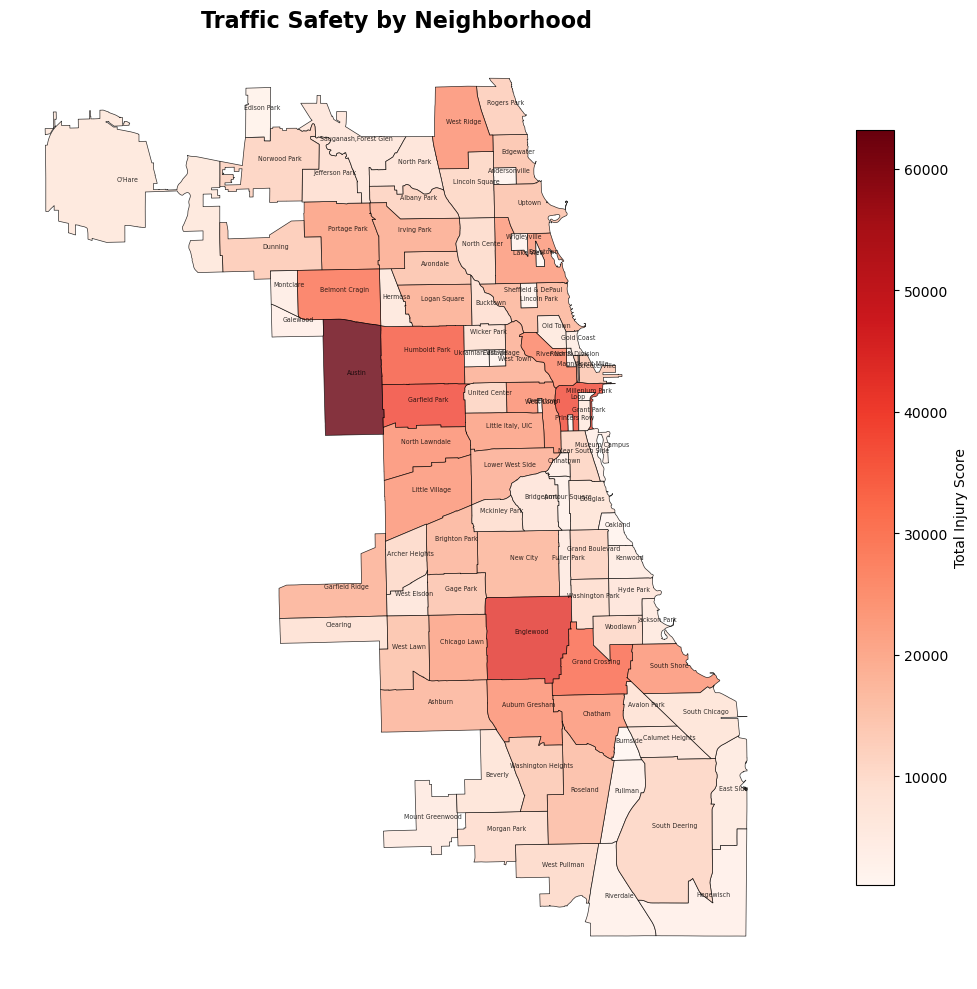

In [149]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt

neighborhoods = pd.read_csv("Neighborhoods_2012b_20251209.csv")
neighborhoods['geometry'] = neighborhoods['the_geom'].apply(wkt.loads)
gdf_neighborhoods = gpd.GeoDataFrame(neighborhoods, geometry='geometry', crs='EPSG:4326')

crash_gdf = gpd.GeoDataFrame(
    crash_injury_filtered,
    geometry=gpd.points_from_xy(crash_injury_filtered.LONGITUDE, crash_injury_filtered.LATITUDE),
    crs="EPSG:4326"
)

neighborhoods_with_crashes = gpd.sjoin(
    gdf_neighborhoods, 
    crash_gdf, 
    how='left', 
    predicate='contains'
)

injury_scores = neighborhoods_with_crashes.groupby(neighborhoods_with_crashes.index)['INJURIES_SCORE'].sum()
gdf_neighborhoods['Total Injury Score'] = injury_scores
gdf_neighborhoods['Total Injury Score'] = gdf_neighborhoods['Total Injury Score'].fillna(0)

name_column = 'PRI_NEIGH'
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf_neighborhoods.plot(
    column='Total Injury Score',
    ax=ax,
    cmap='Reds',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8,
    legend=True,
    legend_kwds={
        'label': 'Total Injury Score',
        'orientation': 'vertical',
        'shrink': 0.8
    }
)

for idx, row in gdf_neighborhoods.iterrows():
    centroid = row.geometry.centroid
    
    if name_column in row:
        name = row[name_column]
    else:
        name = f"Neighborhood {idx}"
    
    ax.annotate(
        text=name,
        xy=(centroid.x, centroid.y),
        xytext=(3, 3),  
        textcoords="offset points",
        fontsize=4.5,
        alpha=0.8,
        ha='center'
    )

ax.set_title('Traffic Safety by Neighborhood', fontsize=16, fontweight='bold')
ax.set_axis_off()  
plt.tight_layout()
plt.show()

In [155]:
gdf_neighborhoods.sort_values(by = 'Total Injury Score', ascending = False).head(20)


,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,Total Injury Score
94,MULTIPOLYGON (((-87.75619515209075 41.91546954...,Austin,AUSTIN,"170,037,750.826","55,473.345911","MULTIPOLYGON (((-87.7562 41.91547, -87.75588 4...",63213.5
19,MULTIPOLYGON (((-87.62854256542131 41.79413908...,Englewood,ENGLEWOOD,"173,600,015.009","56,144.046048","MULTIPOLYGON (((-87.62854 41.79414, -87.62853 ...",42591.5
5,MULTIPOLYGON (((-87.69540013130901 41.88818507...,Garfield Park,GARFIELD PARK,"89,976,069.5947","44,460.91922","MULTIPOLYGON (((-87.6954 41.88819, -87.6952 41...",39153.5
26,MULTIPOLYGON (((-87.61397431379372 41.88840881...,Loop,LOOP,"31,485,185.0318","52,640.907563","MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ...",38590.5
4,MULTIPOLYGON (((-87.74059567509266 41.88782316...,Humboldt Park,HUMBOLDT PARK,"125,010,425.593","46,126.751351","MULTIPOLYGON (((-87.7406 41.88782, -87.7406 41...",36108.0
20,MULTIPOLYGON (((-87.61562233042915 41.78023913...,Grand Crossing,"SOUTH SHORE, GRAND CROSSING","98,853,167.7093","54,645.3303","MULTIPOLYGON (((-87.61562 41.78024, -87.61562 ...",33260.5
93,MULTIPOLYGON (((-87.74142999502229 41.91698483...,Belmont Cragin,"BELMONT CRAGIN,HERMOSA","109,099,407.211","43,311.706886","MULTIPOLYGON (((-87.74143 41.91698, -87.74141 ...",31717.0
97,MULTIPOLYGON (((-87.63144510787805 41.90390085...,River North,RIVER NORTH,"38,766,442.5194","31,506.03781","MULTIPOLYGON (((-87.63145 41.9039, -87.63144 4...",28064.0
40,MULTIPOLYGON (((-87.64446845179371 41.85995449...,West Loop,WEST LOOP,"52,945,063.8967","43,907.671821","MULTIPOLYGON (((-87.64447 41.85995, -87.64449 ...",26231.0
6,MULTIPOLYGON (((-87.72023936012896 41.86986908...,North Lawndale,NORTH LAWNDALE,"89,487,422.0244","44,959.459663","MULTIPOLYGON (((-87.72024 41.86987, -87.71965 ...",26200.5


In [ ]:
gdf_neighborhoods.sort_values(by = 'Total Injury Score', ascending = False).head(15)


In [152]:
gdf_neighborhoods['Total Injury Score'].describe()


count       98.000000
mean     13636.301020
std      10787.977759
min       1092.000000
25%       5829.125000
50%      10764.250000
75%      19202.250000
max      63213.500000
Name: Total Injury Score, dtype: float64

In [154]:
crash_injury_filtered['INJURIES_SCORE'].describe()

count    991090.000000
mean          1.349047
std           1.122410
min           0.000000
25%           1.000000
50%           1.000000
75%           1.500000
max          44.000000
Name: INJURIES_SCORE, dtype: float64

### b) Analysis 2

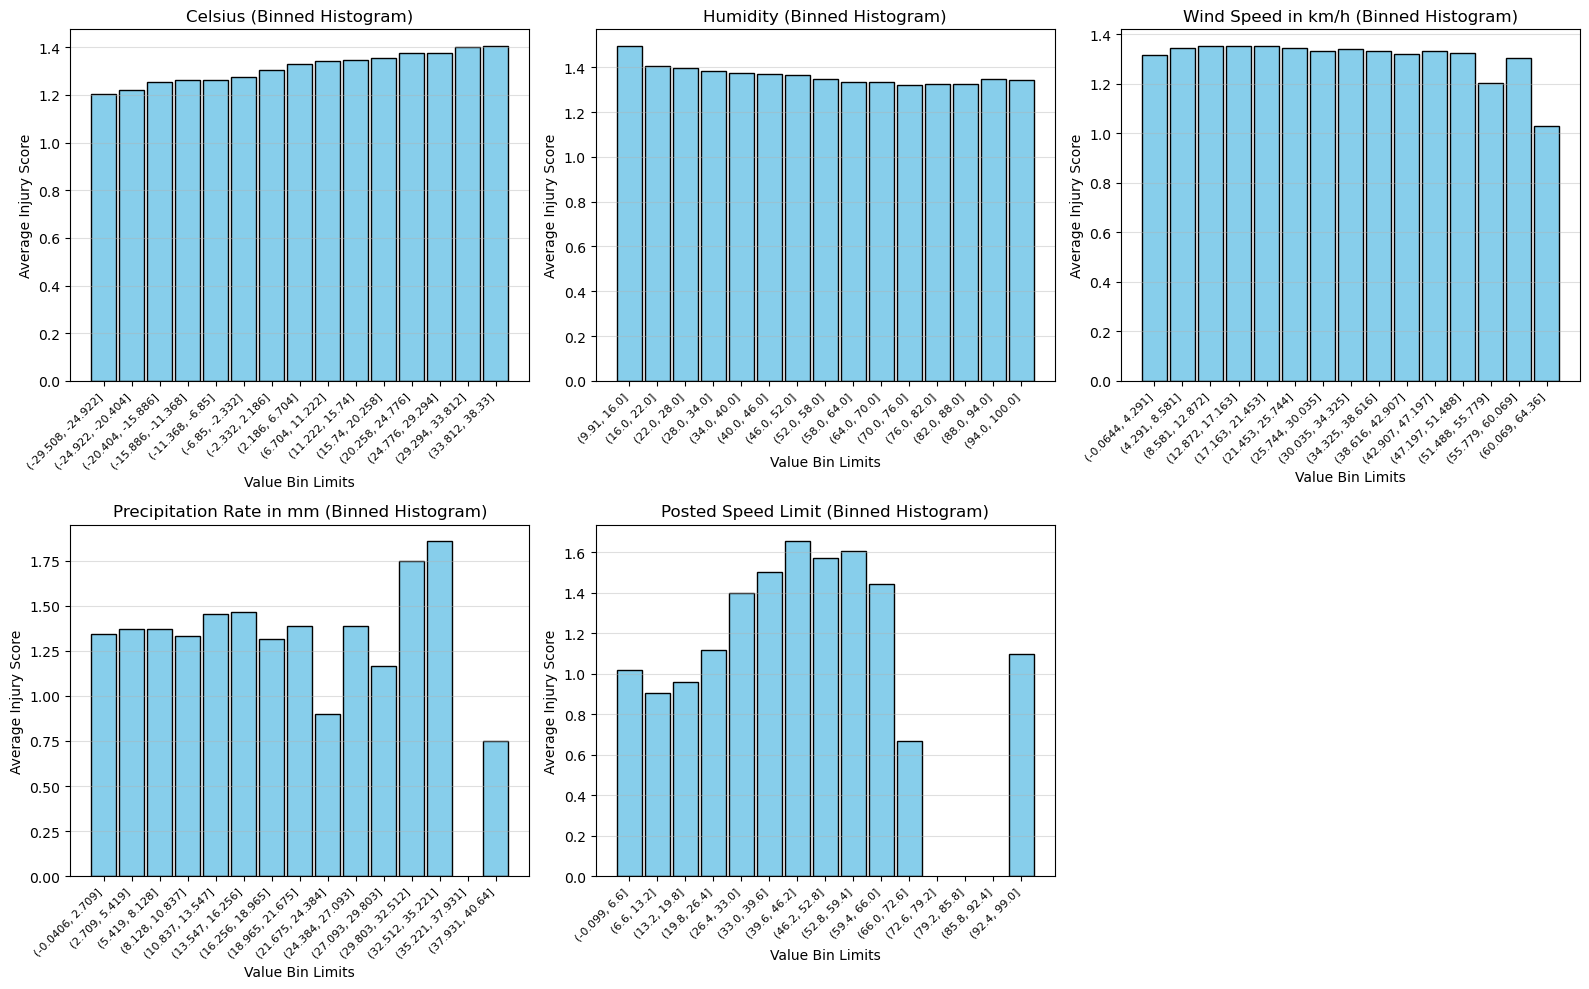

In [266]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

num_weather_vars = [
    'Temperature_C',
    'Humidity_%',
    'Speed in km/h',
    'Precipitation Rate in mm',
    'POSTED_SPEED_LIMIT']

num_weather_vars_names = [
    'Celsius',
    'Humidity',
    'Wind Speed in km/h',
    'Precipitation Rate in mm',
    'Posted Speed Limit']
n = len(num_weather_vars)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
axes = axes.flatten()

for ax, col, name in zip(axes, num_weather_vars, num_weather_vars_names):

    data = merged_crash[col]

    bins = pd.cut(data, bins=15)

    bin_means = merged_crash[[col, "INJURIES_SCORE"]].groupby(bins)["INJURIES_SCORE"].mean()

    ax.bar(
        x=range(len(bin_means)),
        height=bin_means.values,
        width=0.9,
        edgecolor="black",
        color="skyblue"
    )

    ax.set_xticks(range(len(bin_means)))
    ax.set_xticklabels(
        [str(interval) for interval in bin_means.index],
        rotation=45, ha="right", fontsize=8
    )

    ax.set_title(f"{name} (Binned Histogram)")
    ax.set_xlabel("Value Bin Limits")
    ax.set_ylabel("Average Injury Score")
    ax.grid(axis='y', alpha=0.4)

for i in range(len(num_weather_vars), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [288]:
#correlations
merged_crash[['Temperature_C',
    'Humidity_%',
    'Speed in km/h',
    'Precipitation Rate in mm',
    'POSTED_SPEED_LIMIT', 
    "INJURIES_SCORE"]].corr()['INJURIES_SCORE'].drop('INJURIES_SCORE')

Temperature_C               0.030251
Humidity_%                 -0.015567
Speed in km/h              -0.001528
Precipitation Rate in mm    0.003676
POSTED_SPEED_LIMIT          0.122221
Name: INJURIES_SCORE, dtype: float64

In [271]:
for i in num_weather_vars:
    print(i)
    print(merged_crash[i].describe())


Temperature_C
count    872839.000000
mean         13.382575
std          11.591353
min         -29.440000
25%           3.890000
50%          14.440000
75%          23.330000
max          38.330000
Name: Temperature_C, dtype: float64
Humidity_%
count    872839.000000
mean         61.421162
std          17.996642
min          10.000000
25%          48.000000
50%          61.000000
75%          75.000000
max         100.000000
Name: Humidity_%, dtype: float64
Speed in km/h
count    872839.000000
mean         17.063050
std           8.234937
min           0.000000
25%          11.260000
50%          16.090000
75%          22.530000
max          64.360000
Name: Speed in km/h, dtype: float64
Precipitation Rate in mm
count    872839.000000
mean          0.096517
std           0.807710
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.640000
Name: Precipitation Rate in mm, dtype: float64
POSTED_SPEED_LIMIT
count    872839.000000
mean  

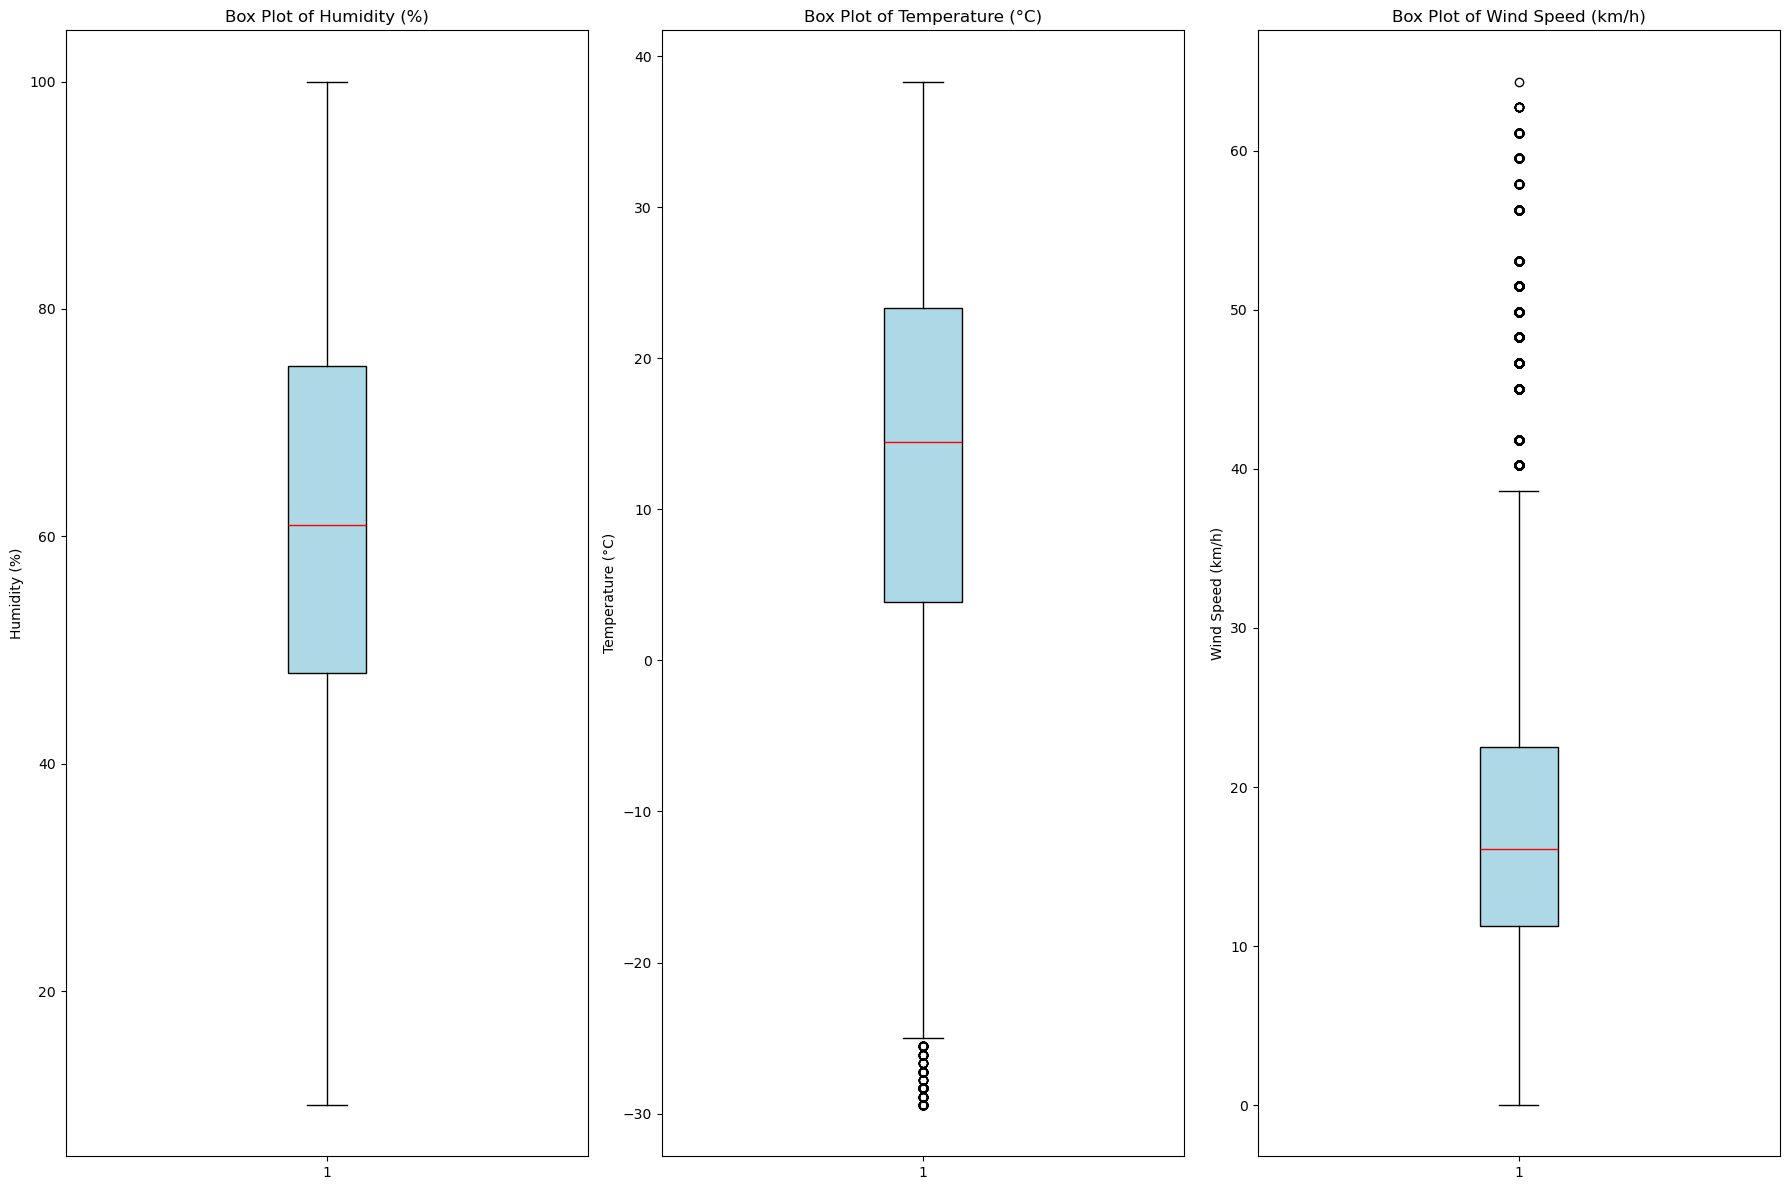

In [431]:
num_vars = [
    'Humidity_%',
    'Temperature_C',
    'Speed in km/h'
]

num_var_names = [
    'Humidity (%)',
    'Temperature (°C)',
    'Wind Speed (km/h)'
]

n = len(num_vars)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

for ax, col, name in zip(axes, num_vars, num_var_names):

    data = merged_crash[col].dropna()

    bp = ax.boxplot(
        data,
        vert=True,
        patch_artist=True,      # allows facecolor
        boxprops=dict(facecolor="lightblue", color="black"),
        medianprops=dict(color="red"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black")
    )

    ax.set_title(f"Box Plot of {name}")
    ax.set_ylabel(name)

# Turn off unused axes
for i in range(len(num_vars), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [432]:
#showing specific values of each box plot bin
for i in num_vars:
    data = merged_crash[i]

    print(data.describe())

count    872839.000000
mean         61.421162
std          17.996642
min          10.000000
25%          48.000000
50%          61.000000
75%          75.000000
max         100.000000
Name: Humidity_%, dtype: float64
count    872839.000000
mean         13.382575
std          11.591353
min         -29.440000
25%           3.890000
50%          14.440000
75%          23.330000
max          38.330000
Name: Temperature_C, dtype: float64
count    872839.000000
mean         17.063050
std           8.234937
min           0.000000
25%          11.260000
50%          16.090000
75%          22.530000
max          64.360000
Name: Speed in km/h, dtype: float64


### c) Analysis 3 

#### Component 1

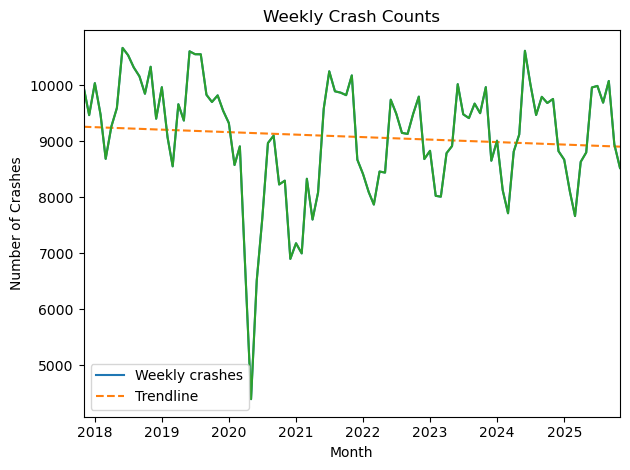

In [402]:

crash_date_filtered["CRASH_DATE"] = pd.to_datetime(crash_date_filtered["CRASH_DATE"])

weekly_counts = (
    crash_date_filtered.resample("M", on="CRASH_DATE")
      .size()
      .reset_index(name="num_crashes")
)



x = np.arange(len(weekly_counts))
y = weekly_counts["num_crashes"].values

coef = np.polyfit(x, y, 1)
trend = coef[0] * x + coef[1]

weekly_counts["trendline"] = trend
plt.plot(weekly_counts["CRASH_DATE"], weekly_counts["num_crashes"], label="Weekly crashes")
plt.plot(weekly_counts["CRASH_DATE"], weekly_counts["trendline"], linestyle="--", label="Trendline")
plt.legend()


plt.plot(weekly_counts["CRASH_DATE"], weekly_counts["num_crashes"])
plt.xlabel("Month")
plt.ylabel("Number of Crashes")
plt.title("Weekly Crash Counts")
plt.xlim(weekly_counts["CRASH_DATE"].min(), weekly_counts["CRASH_DATE"].max())
plt.tight_layout()
plt.show()

In [382]:
#trendline slope is
print(coef[0])

-3.697651483273788


In [424]:
#trendline slope after 2022
weekly_counts = weekly_counts[weekly_counts['CRASH_DATE'] > pd.to_datetime('2022-01-01')]
x = np.arange(len(weekly_counts))
y = weekly_counts["num_crashes"].values

coef = np.polyfit(x, y, 1)
print(coef[0])


-3.9345674486804683


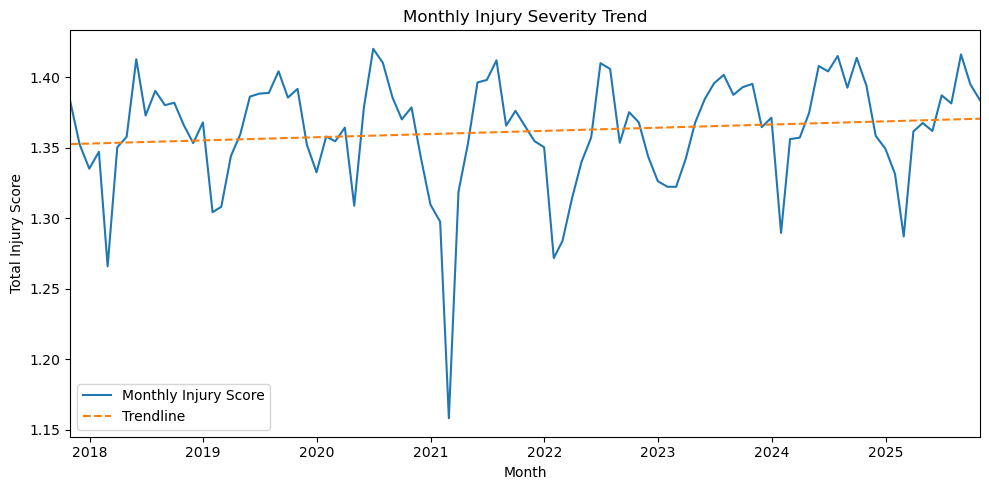

In [385]:

monthly_injury = (
    crash_date_filtered.resample("M", on="CRASH_DATE")["INJURIES_SCORE"]
    .mean()
    .reset_index(name="injury_score")
)

x = np.arange(len(monthly_injury))
y = monthly_injury["injury_score"].values

coef = np.polyfit(x, y, 1)
trend = coef[0] * x + coef[1]

monthly_injury["trendline"] = trend

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_injury["CRASH_DATE"], monthly_injury["injury_score"], label="Monthly Injury Score")
plt.plot(monthly_injury["CRASH_DATE"], monthly_injury["trendline"], linestyle="--", label="Trendline")

plt.xlabel("Month")
plt.ylabel("Total Injury Score")
plt.title("Monthly Injury Severity Trend")
plt.legend()
plt.xlim(monthly_injury["CRASH_DATE"].min(), monthly_injury["CRASH_DATE"].max())
plt.tight_layout()
plt.show()


In [386]:
#trendline slope is
print(coef[0])

0.00018771488355951265


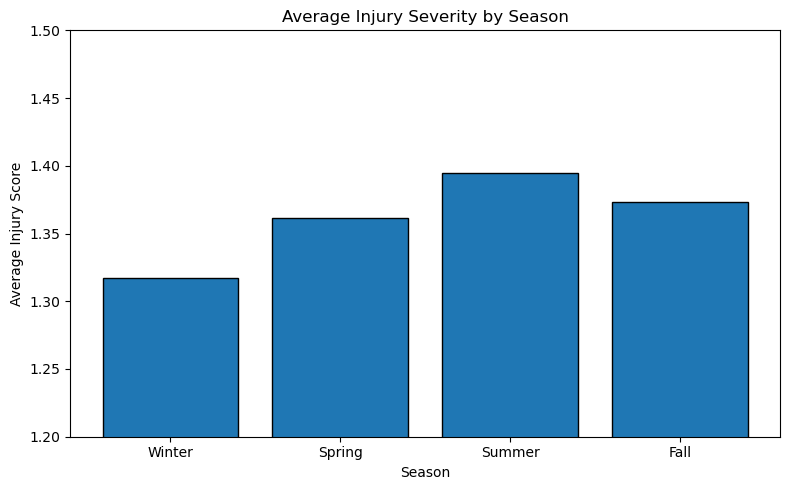

In [406]:
monthly_injury = (
    crash_date_filtered
        .resample("M", on="CRASH_DATE")["INJURIES_SCORE"]
        .mean()
        .reset_index(name="injury_score")
)

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

monthly_injury["Season"] = monthly_injury["CRASH_DATE"].dt.month.apply(get_season)

seasonal_injury = (
    monthly_injury.groupby("Season")["injury_score"]
    .mean()
    .reindex(["Winter", "Spring", "Summer", "Fall"])  
    .reset_index()
)

plt.figure(figsize=(8, 5))
plt.bar(seasonal_injury["Season"], seasonal_injury["injury_score"], edgecolor="black")

plt.xlabel("Season")
plt.ylabel("Average Injury Score")
plt.ylim(1.2, 1.5) 
plt.title("Average Injury Severity by Season")
plt.tight_layout()
plt.show()


In [404]:
seasonal_injury.head()

,Season,injury_score
0,Winter,1.316814
1,Spring,1.361230
2,Summer,1.394585
3,Fall,1.373639


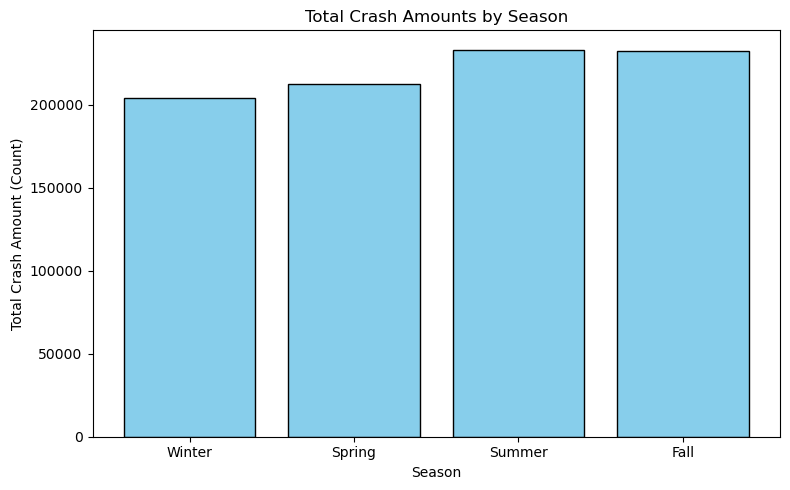

In [412]:
monthly_crash = (
    crash_date_filtered.set_index("CRASH_DATE")
    .resample("M")
    .size()
    .reset_index(name="monthly_crash_count")
)

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

monthly_crash["Season"] = monthly_crash["CRASH_DATE"].dt.month.apply(get_season)

seasonal_crash_totals = (
    monthly_crash.groupby("Season")["monthly_crash_count"]
    .sum()
    .reindex(["Winter", "Spring", "Summer", "Fall"])
    .reset_index(name="total_crashes")
)

plt.figure(figsize=(8, 5))
plt.bar(
    seasonal_crash_totals["Season"], 
    seasonal_crash_totals["total_crashes"], 
    color='skyblue', # Added color
    edgecolor="black"
)

plt.xlabel("Season")
plt.ylabel("Total Crash Amount (Count)") # Corrected label
plt.title("Total Crash Amounts by Season")
plt.tight_layout()
plt.show()

In [416]:
seasonal_crash_totals.head()

,Season,total_crashes
0,Winter,203631
1,Spring,212238
2,Summer,233011
3,Fall,231988
